# Compare swr detection with mua detection

The idea is that units should increase their firing during HPC ripples. Being so, ripples without increased unit firing might be false positives. 

In [1]:
import glob
import pandas as pd
import os
import pickle 
import numpy as np
import math 
from matplotlib import pyplot as plt

import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import itertools
from ripple_detection.core import get_multiunit_population_firing_rate

from scipy import stats
from ripple_detection.core import gaussian_smooth, get_envelope

from neurodsp.filt import filter_signal



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Import mua data

In [2]:
df_mua = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\multiunit_data\post_processed\mua_df.csv')
df_mua

Unnamed: 0  start_time   end_time  peak_time  ripple_duration area  \
0               0     64.0895    64.3285    64.2555            0.239  ca1   
1               1     69.6875    69.8525    69.7725            0.165  ca1   
2               2     75.6615    75.7805    75.7065            0.119  ca1   
3               3     76.6735    76.8635    76.7755            0.190  ca1   
4               4     82.6235    82.7045    82.6595            0.081  ca1   
...           ...         ...        ...        ...              ...  ...   
64604       64604   1474.8415  1475.0365  1474.9495            0.195  ca1   
64605       64605   1517.8405  1517.9865  1517.9345            0.146  ca1   
64606       64606   1517.9935  1518.2105  1518.1185            0.217  ca1   
64607       64607   1532.9235  1532.9785  1532.9515            0.055  ca1   
64608       64608   1538.7055  1538.8835  1538.8165            0.178  ca1   

                       session ep_type    group      rat  
0      LEM3116_S20180715121821   track  control  LEM3116  
1      LEM3116_S20180715121821   track  control  LEM3116  
2      LEM3116_S20180715121821   track  control  LEM3116  
3      LEM3116_S20180715121821   track  control  LEM3116  
4      LEM3116_S20180715121821   track  control  LEM3116  
...                        ...     ...      ...      ...  
64604     RH16_S20161207130000   track      pae     RH16  
64605     RH16_S20161207130000   track      pae     RH16  
64606     RH16_S20161207130000   track      pae     RH16  
64607     RH16_S20161207130000   track      pae     RH16  
64608     RH16_S20161207130000   track      pae     RH16  

[64609 rows x 10 columns]

## load raw swr

In [3]:
save_path = "F:/Projects/PAE_PlaceCell/analysis/swr_data/"
sessions = glob.glob(save_path + '*.pkl')
ripple_map = []
filtered_map = []
phase_map = []
amp_map = []

freq_map = []

df_swr=pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        ripple_times = pickle.load(f)
        ripple_maps = pickle.load(f)
    ripple_map.append(ripple_maps["ripple_map"])
    filtered_map.append(ripple_maps['filtered_map'])
    phase_map.append(ripple_maps['phase_map'])
    amp_map.append(ripple_maps['amp_map'])
    freq_map.append(ripple_maps['freq_map'])

    # add data frame of ripple features and add session id
    base = os.path.basename(session)
    ripple_times['session'] = os.path.splitext(base)[0]
    df_swr = df_swr.append(ripple_times,ignore_index=True)

ripple_map = np.vstack(ripple_map)     
filtered_map = np.vstack(filtered_map)     
phase_map = np.vstack(phase_map)     
amp_map = np.vstack(amp_map)     
freq_map = np.vstack(freq_map) 

# make maps dict 
ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}
df_swr

ripple_number   start_time     end_time  ripple_duration   max_emg  \
0                  0    43.192000    43.520800         0.328800  0.996477   
1                  1    45.066400    45.252000         0.185600  0.992112   
2                  2    45.326400    46.366400         1.040000  0.995808   
3                  3    46.398400    46.705600         0.307200  0.989954   
4                  4    46.728000    46.848800         0.120800  0.996390   
...              ...          ...          ...              ...       ...   
91021             21  1440.985476  1441.183873         0.198398  1.000000   
91022             22  1448.622989  1448.681388         0.058399  1.000000   
91023             23  1450.061372  1450.114172         0.052799  1.000000   
91024             24  1526.378903  1526.514902         0.135998  1.000000   
91025             25  1549.299442  1549.429841         0.130399  1.000000   

         peak_time  peak_channel  peak_amplitude   peak_freq   clipped  \
0        43.459200             6       31.291268  173.719424  0.006667   
1        45.192000             6        9.181491  136.852540  0.000000   
2        45.548800             7        8.901772  130.036443  0.000000   
3        46.599200             3        8.671494  175.020480  0.000000   
4        46.800000             3        6.160733  193.076538  0.006667   
...            ...           ...             ...         ...       ...   
91021  1441.059875             2        4.625713  201.509249  0.013333   
91022  1448.644588             0        3.333549  192.687751  0.000000   
91023  1450.094172             2        3.191887  216.566541  0.013333   
91024  1526.415703             0        3.197711  108.029895  0.000000   
91025  1549.359442             3       51.975368  155.915173  0.000000   

                       session  
0      LEM3116_S20180715121821  
1      LEM3116_S20180715121821  
2      LEM3116_S20180715121821  
3      LEM3116_S20180715121821  
4      LEM3116_S20180715121821  
...                        ...  
91021     RH16_S20161207130000  
91022     RH16_S20161207130000  
91023     RH16_S20161207130000  
91024     RH16_S20161207130000  
91025     RH16_S20161207130000  

[91026 rows x 11 columns]

### Add area to ripple df

In [37]:
channel_list = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\channel_list.csv')
# channel_list

area = []
for ripple in df_swr.itertuples():
    idx = (ripple.session == channel_list.session) & (ripple.peak_channel+1 == channel_list.channel)
    area.append(channel_list[idx].area.iloc[0])
    
df_swr['area'] = area
df_swr

<ipython-input-37-5013a5852831>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_swr['area'] = area


ripple_number   start_time     end_time  ripple_duration   max_emg  \
0                  0    43.192000    43.520800         0.328800  0.996477   
1                  1    45.066400    45.252000         0.185600  0.992112   
3                  3    46.398400    46.705600         0.307200  0.989954   
4                  4    46.728000    46.848800         0.120800  0.996390   
5                  5    53.145600    53.850400         0.704800  0.997383   
...              ...          ...          ...              ...       ...   
91021             21  1440.985476  1441.183873         0.198398  1.000000   
91022             22  1448.622989  1448.681388         0.058399  1.000000   
91023             23  1450.061372  1450.114172         0.052799  1.000000   
91024             24  1526.378903  1526.514902         0.135998  1.000000   
91025             25  1549.299442  1549.429841         0.130399  1.000000   

         peak_time  peak_channel  peak_amplitude   peak_freq   clipped  \
0        43.459200             6       31.291268  173.719424  0.006667   
1        45.192000             6        9.181491  136.852540  0.000000   
3        46.599200             3        8.671494  175.020480  0.000000   
4        46.800000             3        6.160733  193.076538  0.006667   
5        53.292800             4       61.826521  141.171062  0.000000   
...            ...           ...             ...         ...       ...   
91021  1441.059875             2        4.625713  201.509249  0.013333   
91022  1448.644588             0        3.333549  192.687751  0.000000   
91023  1450.094172             2        3.191887  216.566541  0.013333   
91024  1526.415703             0        3.197711  108.029895  0.000000   
91025  1549.359442             3       51.975368  155.915173  0.000000   

                       session area  
0      LEM3116_S20180715121821  ca1  
1      LEM3116_S20180715121821  ca1  
3      LEM3116_S20180715121821  ca1  
4      LEM3116_S20180715121821  ca1  
5      LEM3116_S20180715121821  ca1  
...                        ...  ...  
91021     RH16_S20161207130000  ca1  
91022     RH16_S20161207130000  ca1  
91023     RH16_S20161207130000  ca1  
91024     RH16_S20161207130000  ca1  
91025     RH16_S20161207130000  ca1  

[90930 rows x 12 columns]

### do some slight processing to remove some obvious false positives

Below, I keep ripple that are less than 1 second

In [40]:
# remove less than a second from swr
idx = df_swr.ripple_duration < 1
for key in ripple_maps.keys():
        ripple_maps[key] = ripple_maps[key][idx]
df_swr = df_swr[idx]

# remove less than a second from mua
df_mua = df_mua[df_mua.ripple_duration < 1]


display(df_swr)
display(df_mua)

ripple_number   start_time     end_time  ripple_duration   max_emg  \
0                  0    43.192000    43.520800         0.328800  0.996477   
1                  1    45.066400    45.252000         0.185600  0.992112   
3                  3    46.398400    46.705600         0.307200  0.989954   
4                  4    46.728000    46.848800         0.120800  0.996390   
5                  5    53.145600    53.850400         0.704800  0.997383   
...              ...          ...          ...              ...       ...   
91021             21  1440.985476  1441.183873         0.198398  1.000000   
91022             22  1448.622989  1448.681388         0.058399  1.000000   
91023             23  1450.061372  1450.114172         0.052799  1.000000   
91024             24  1526.378903  1526.514902         0.135998  1.000000   
91025             25  1549.299442  1549.429841         0.130399  1.000000   

         peak_time  peak_channel  peak_amplitude   peak_freq   clipped  \
0        43.459200             6       31.291268  173.719424  0.006667   
1        45.192000             6        9.181491  136.852540  0.000000   
3        46.599200             3        8.671494  175.020480  0.000000   
4        46.800000             3        6.160733  193.076538  0.006667   
5        53.292800             4       61.826521  141.171062  0.000000   
...            ...           ...             ...         ...       ...   
91021  1441.059875             2        4.625713  201.509249  0.013333   
91022  1448.644588             0        3.333549  192.687751  0.000000   
91023  1450.094172             2        3.191887  216.566541  0.013333   
91024  1526.415703             0        3.197711  108.029895  0.000000   
91025  1549.359442             3       51.975368  155.915173  0.000000   

                       session area  
0      LEM3116_S20180715121821  ca1  
1      LEM3116_S20180715121821  ca1  
3      LEM3116_S20180715121821  ca1  
4      LEM3116_S20180715121821  ca1  
5      LEM3116_S20180715121821  ca1  
...                        ...  ...  
91021     RH16_S20161207130000  ca1  
91022     RH16_S20161207130000  ca1  
91023     RH16_S20161207130000  ca1  
91024     RH16_S20161207130000  ca1  
91025     RH16_S20161207130000  ca1  

[90930 rows x 12 columns]

Unnamed: 0  start_time   end_time  peak_time  ripple_duration area  \
0               0     64.0895    64.3285    64.2555            0.239  ca1   
1               1     69.6875    69.8525    69.7725            0.165  ca1   
2               2     75.6615    75.7805    75.7065            0.119  ca1   
3               3     76.6735    76.8635    76.7755            0.190  ca1   
4               4     82.6235    82.7045    82.6595            0.081  ca1   
...           ...         ...        ...        ...              ...  ...   
64604       64604   1474.8415  1475.0365  1474.9495            0.195  ca1   
64605       64605   1517.8405  1517.9865  1517.9345            0.146  ca1   
64606       64606   1517.9935  1518.2105  1518.1185            0.217  ca1   
64607       64607   1532.9235  1532.9785  1532.9515            0.055  ca1   
64608       64608   1538.7055  1538.8835  1538.8165            0.178  ca1   

                       session ep_type    group      rat  
0      LEM3116_S20180715121821   track  control  LEM3116  
1      LEM3116_S20180715121821   track  control  LEM3116  
2      LEM3116_S20180715121821   track  control  LEM3116  
3      LEM3116_S20180715121821   track  control  LEM3116  
4      LEM3116_S20180715121821   track  control  LEM3116  
...                        ...     ...      ...      ...  
64604     RH16_S20161207130000   track      pae     RH16  
64605     RH16_S20161207130000   track      pae     RH16  
64606     RH16_S20161207130000   track      pae     RH16  
64607     RH16_S20161207130000   track      pae     RH16  
64608     RH16_S20161207130000   track      pae     RH16  

[64294 rows x 10 columns]

In [41]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch

def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session.iloc[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def get_spikes(filename):
    data = hdf5storage.loadmat(filename,variable_names=['Spikes'])
    spike_times=data['Spikes']
    spike_times=np.squeeze(spike_times)
    for i in range(spike_times.shape[0]):
        spike_times[i]=np.squeeze(spike_times[i])
    return spike_times

#### Pull in lfp and mua to plot example

In [42]:
def plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,session,lims=20,rip_n=0):
    # look at current session only
    df = df[(df.session == session)]
    
    # find time window around ripple
    lower_lim = df.peak_time.iloc[rip_n] - lims
    upper_lim = df.peak_time.iloc[rip_n] + lims
    
    # locate channel that maximized ripple power
    peak_ch = df.peak_channel.iloc[rip_n]
    
    # restrict to just that time window
    temp_df = df[(df.start_time >= lower_lim) & (df.end_time <= upper_lim)]
    
    # find index for time window for lfp
    lfp_idx = (ts_lfp >= lower_lim) & (ts_lfp <= upper_lim)
    
    # zscore lfp for plotting
    zscore_lfp = stats.zscore(lfp[lfp_idx,peak_ch],axis=0)
    
    # plot lfp trace
    ax.plot(ts_lfp[lfp_idx],zscore_lfp + 5,color='#0b032a',label='raw lfp')  
    
    # bandpass filter lfp trace to ripple range and zscore for plotting
    signal = stats.zscore(filter_signal(lfp[lfp_idx,peak_ch],1250,'bandpass',(80,250),remove_edges=False),axis=0)    
    
    # plot filtered signal
    ax.plot(ts_lfp[lfp_idx],signal,color='#621940',alpha=.5,label='filtered lfp') 
    
    # get envelope
    smooth_envelope = gaussian_smooth(get_envelope(signal),0.004,1250)
    ax.plot(ts_lfp[lfp_idx],smooth_envelope,color='#843b62',label='envelope') 
    
    # find index for time window for mua
    mua_idx = (ts_mua >= lower_lim) & (ts_mua <= upper_lim)
    
    # plot zscored mua
    ax.plot(ts_mua[mua_idx],stats.zscore(firing_rate[mua_idx],axis=0)-10,color='#ED553B',label='mua')

    # plot spike raster within window
    for i,s in enumerate(spike_times):
        s = s[(s >= lower_lim) & (s <= upper_lim)]
        ax.plot(s,np.zeros(len(s))-15-i,'|',color='#0b032a')

    # plot swr times within window
    for ripple in temp_df.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#843b62', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#843b62', zorder=1000)

    # plot mua times within window
    temp_df_mua = df_mua[(df_mua.session == session) & (df_mua.start_time >= lower_lim) & (df_mua.end_time <= upper_lim)]
    for ripple in temp_df_mua.itertuples():
        ax.axvspan(ripple.start_time, ripple.end_time, alpha=0.3, color='#ED553B', zorder=-1000)
        ax.axvline(ripple.peak_time, color='#ED553B', zorder=1000)
        
    ax.legend(loc='upper right')
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('time (sec)')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)

### load data to plot example

In [43]:
session = np.where(df_swr.session=='LEM3216_S20190805141510')[0][0]
# session = np.where(df_swr.session=='LS19_S20170622141707')[0][0]

lfp,ts_lfp = get_lfp(df_swr,session)

# load spikes
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
spike_times = get_spikes(data_path+df_swr.session.iloc[session]+'.mat')

# bin spikes into single vector
st = list(itertools.chain.from_iterable(spike_times))
dt = 0.001
multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
# timestamps for binned spikes
ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
firing_rate = get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

### plot example

* Shaded purple are detected ripple events

* Shaded orange are detected mua events

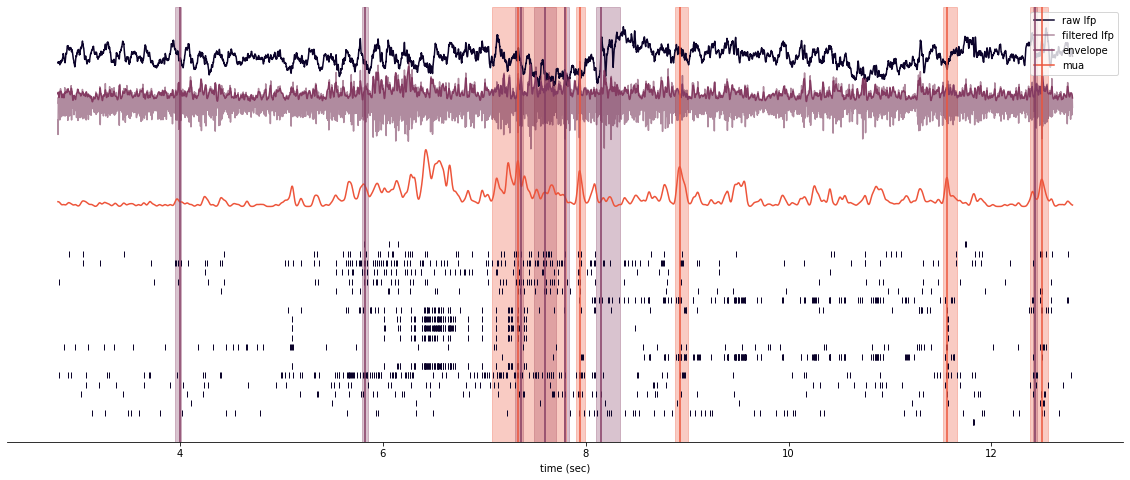

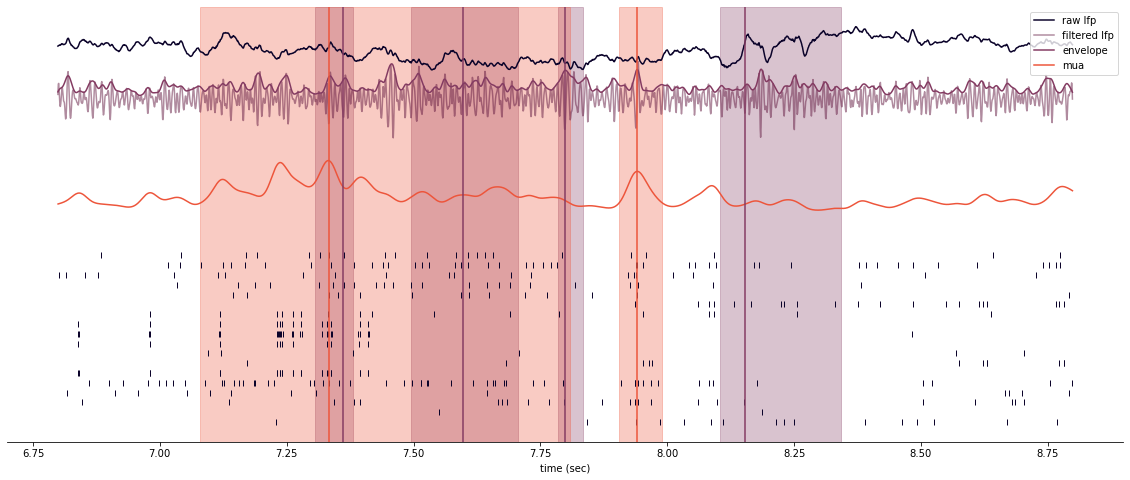

In [44]:
rip_n = 5
fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 8))    
plot_traces(ax,df_swr,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### check to find detected ripples overlap with of mua events

In [45]:
ripple_map_temp = []
filtered_map_temp = []
phase_map_temp = []
amp_map_temp = []
freq_map_temp = []

df=pd.DataFrame()

from IPython.display import clear_output
i=1

condition = []
for event in df_mua.itertuples():
    clear_output(wait=True)
    
    condition.append((df_swr.session == event.session) & (df_swr.peak_time >= event.start_time) & (df_swr.end_time <= event.end_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.start_time) & (df_swr.end_time >= event.start_time))
    condition.append((df_swr.session == event.session) & (df_swr.start_time <= event.end_time) & (df_swr.end_time >= event.end_time))
    idx = condition[0] | condition[1] | condition[2]
    condition = [] 
        
    ripple_map_temp.append(ripple_maps["ripple_map"][idx])
    filtered_map_temp.append(ripple_maps["filtered_map"][idx])
    phase_map_temp.append(ripple_maps["phase_map"][idx])
    amp_map_temp.append(ripple_maps["amp_map"][idx])
    freq_map_temp.append(ripple_maps["freq_map"][idx])
    
    event_times = df_swr[idx]
    df = df.append(event_times,ignore_index=True)
    
    i+=1
    print("Current progress:",np.round(i/len(df_mua)*100,2),"%")
    
ripple_map = np.vstack(ripple_map_temp)     
filtered_map = np.vstack(filtered_map_temp)     
phase_map = np.vstack(phase_map_temp)     
amp_map = np.vstack(amp_map_temp)     
freq_map = np.vstack(freq_map_temp)  

ripple_maps = {
    "ripple_map": ripple_map,
    "filtered_map": filtered_map,
    "phase_map": phase_map,
    "amp_map": amp_map,
    "freq_map":freq_map
}

df 

Current progress: 100.0 %


ripple_number   start_time     end_time  ripple_duration   max_emg  \
0                 22   211.247200   211.327200         0.080000  0.990871   
1                 60   517.919200   518.311200         0.392000  0.995188   
2                 72   607.938400   608.326400         0.388000  0.990928   
3                 80   675.985600   676.139200         0.153600  0.994272   
4                100   933.226400   933.424000         0.197600  0.992893   
...              ...          ...          ...              ...       ...   
18728             25   255.450400   255.599200         0.148800  0.314032   
18729             22   149.384000   149.505600         0.121600  0.133732   
18730             32   233.419200   233.576000         0.156800  0.260312   
18731             36   270.288000   270.410400         0.122400  0.065024   
18732             20  1396.139586  1396.249985         0.110399  1.000000   

         peak_time  peak_channel  peak_amplitude   peak_freq   clipped  \
0       211.296000             3        5.566472  213.605249  0.000000   
1       518.087200             7       29.168512  203.155556  0.000000   
2       607.964000             3        7.932019  103.616382  0.000000   
3       676.074400             7        5.077734  173.913383  0.000000   
4       933.278400             7       27.285162  119.721685  0.000000   
...            ...           ...             ...         ...       ...   
18728   255.533600             7        8.094016  105.746020  0.000000   
18729   149.436800             6       12.060743  186.017137  0.000000   
18730   233.496000             7        8.145433  110.793201  0.000000   
18731   270.328800             0        4.390508  174.380797  0.000000   
18732  1396.172386             0        2.754715  165.426493  0.013333   

                       session area  
0      LEM3116_S20180715121821  ca1  
1      LEM3116_S20180715121821  ca1  
2      LEM3116_S20180715121821  ca1  
3      LEM3116_S20180715121821  ca1  
4      LEM3116_S20180715121821  ca1  
...                        ...  ...  
18728     RH16_S20161126145021  ca1  
18729     RH16_S20161126150318  ca1  
18730     RH16_S20161126150318  ca1  
18731     RH16_S20161126150318  ca1  
18732     RH16_S20161207130000  ca1  

[18733 rows x 12 columns]

### remove duplicates

In [50]:
idx = (~df.start_time.duplicated(keep='first')) & (~df.peak_freq.duplicated(keep='first'))

df = df[idx]
for key in ripple_maps.keys():
    ripple_maps[key] = ripple_maps[key][idx]
df

ripple_number   start_time     end_time  ripple_duration   max_emg  \
0                 22   211.247200   211.327200         0.080000  0.990871   
1                 60   517.919200   518.311200         0.392000  0.995188   
2                 72   607.938400   608.326400         0.388000  0.990928   
3                 80   675.985600   676.139200         0.153600  0.994272   
4                100   933.226400   933.424000         0.197600  0.992893   
...              ...          ...          ...              ...       ...   
18728             25   255.450400   255.599200         0.148800  0.314032   
18729             22   149.384000   149.505600         0.121600  0.133732   
18730             32   233.419200   233.576000         0.156800  0.260312   
18731             36   270.288000   270.410400         0.122400  0.065024   
18732             20  1396.139586  1396.249985         0.110399  1.000000   

         peak_time  peak_channel  peak_amplitude   peak_freq   clipped  \
0       211.296000             3        5.566472  213.605249  0.000000   
1       518.087200             7       29.168512  203.155556  0.000000   
2       607.964000             3        7.932019  103.616382  0.000000   
3       676.074400             7        5.077734  173.913383  0.000000   
4       933.278400             7       27.285162  119.721685  0.000000   
...            ...           ...             ...         ...       ...   
18728   255.533600             7        8.094016  105.746020  0.000000   
18729   149.436800             6       12.060743  186.017137  0.000000   
18730   233.496000             7        8.145433  110.793201  0.000000   
18731   270.328800             0        4.390508  174.380797  0.000000   
18732  1396.172386             0        2.754715  165.426493  0.013333   

                       session area     ep_type    group      rat  
0      LEM3116_S20180715121821  ca1       track  control  LEM3116  
1      LEM3116_S20180715121821  ca1       track  control  LEM3116  
2      LEM3116_S20180715121821  ca1       track  control  LEM3116  
3      LEM3116_S20180715121821  ca1       track  control  LEM3116  
4      LEM3116_S20180715121821  ca1  pedestal_2  control  LEM3116  
...                        ...  ...         ...      ...      ...  
18728     RH16_S20161126145021  ca1       track      pae     RH16  
18729     RH16_S20161126150318  ca1       track      pae     RH16  
18730     RH16_S20161126150318  ca1       track      pae     RH16  
18731     RH16_S20161126150318  ca1       track      pae     RH16  
18732     RH16_S20161207130000  ca1       track      pae     RH16  

[18204 rows x 15 columns]

### add epoch data to dataframe

In [ ]:
def add_epoch_type(df,data_path):
    dicts = {}
    for session in df.session:
        f = h5py.File(data_path+session+'.mat','r')
        ex_ep = []
        for i in range(f['events'].shape[0]):
            ex_ep.append(f['events'][i])
        dicts[session] = ex_ep

    ep_type = ['pedestal_1','track','pedestal_2','cylinder_1','pedestal_3','cylinder_2','pedestal_4']
    df['ep_type'] = np.ones_like(df.session)
    # session_df=pd.DataFrame()
    for session in np.unique(df.session):
        # stack epoch times
        b = np.hstack(dicts[session])

        # add 0 to start to indicate the start of the recording session
        b = np.insert(b,0,0)

        # add the ts of the last ripple of the session to indicate end of session
        b = list(b)
        last_rip = max(df.end_time[df.session == session])
        if b[-1] < last_rip:
            b.append(last_rip)

        # loop through each epoch and label each ripple
        for ep in range(len(b)-1):
            idx = (df.session == session) & (df.peak_time >= b[ep]) & (df.peak_time <= b[ep+1])
            df['ep_type'][idx] = ep_type[ep]

    return df

data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
df = add_epoch_type(df,data_path)


### add group affiliation to dataframe

In [52]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.group[idx] = 'pae'
    return df
    
df = add_group_affiliation(df)    

rat = [s.split('_')[0] for s in df.session]
df['rat']=rat

<ipython-input-52-93740befc31b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-52-93740befc31b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


### get ripple rate

Here, I am looking at how many ripples occured per second out of the valid time epochs where running speed was less than 4cm/sec

In [ ]:
# def get_ripple_rate(df,session,data_path):
#     # get_ripple_rate: returns ripple rate in hz

#     # load position data to get valid session duration
#     pos_df = load_position(data_path + df.session[df.session==session].iloc[0] + '.mat') 
#     # find time that ripples can occur (speeds < 4cm/sec)
#     valid_time = sum(pos_df.speed < 4) * (pos_df.ts.iloc[1] - pos_df.ts.iloc[0]) 
#     # divide the number of ripples by the amount of valid time in seconds to get ripples/sec
#     return sum(df.session == session) / valid_time

# # loop though each session to get ripples/sec
# ripple_rate = [get_ripple_rate(df,session,data_path) for session in pd.unique(df.session)]

# # make new dataframe where each row is a session
# df_ripple_rate = pd.DataFrame()
# df_ripple_rate["ripple_rate"] = ripple_rate

# df_ripple_rate["session"] = pd.unique(df.session)

# df_ripple_rate = add_group_affiliation(df_ripple_rate)

# display(df_ripple_rate)

In [82]:

def get_ripple_rate(df,event,data_path):
    # load position data to get valid session duration
    pos_df = load_position(data_path+event.session+'.mat') 
    # find time that ripples can occur (speeds < 4cm/sec)
    valid_time = sum(pos_df.speed < 4) * (pos_df.ts.iloc[1] - pos_df.ts.iloc[0]) 
    # divide the number of ripples by the amount of valid time in seconds to get ripples/sec
    return event.counts / valid_time

df_ripple_rate = df.groupby(['session','area']).size().reset_index().rename(columns={0:'counts'})
# loop though each session to get ripples/sec
ripple_rate = [get_ripple_rate(df,event,data_path) for event in df_ripple_rate.itertuples()]
df_ripple_rate["ripple_rate"] = ripple_rate
df_ripple_rate = add_group_affiliation(df_ripple_rate)

rat = [s.split('_')[0] for s in df_ripple_rate.session]
df_ripple_rate['rat']=rat

display(df_ripple_rate)


<ipython-input-52-93740befc31b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-52-93740befc31b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


session area  counts  ripple_rate    group
0    LEM3116_S20180715121821  ca1      11     0.010138  control
1    LEM3116_S20180715160836  ca1      40     0.035514  control
2    LEM3116_S20180716115155  ca1       7     0.017809  control
3    LEM3116_S20180716174306  ca1      31     0.021395  control
4    LEM3116_S20180717110938  ca1     438     0.216545  control
..                       ...  ...     ...          ...      ...
216     RH16_S20161021165052  ca1       1     0.006446      pae
217     RH16_S20161030145324  ca1       5     0.022714      pae
218     RH16_S20161126145021  ca1       1     0.012127      pae
219     RH16_S20161126150318  ca1       3     0.029756      pae
220     RH16_S20161207130000  ca1       1     0.001826      pae

[221 rows x 5 columns]

### save new df and maps

In [86]:
if not os.path.exists(save_path+'post_processed'):
    os.mkdir(save_path+'post_processed')

df.to_csv(save_path+'post_processed/swr_df.csv')
df_ripple_rate.to_csv(save_path+'post_processed/df_ripple_rate.csv')

# save file
with open(save_path+'post_processed/swr_df_maps.pkl', 'wb') as f:
    pickle.dump(df, f)
    pickle.dump(ripple_maps, f)

### plot example with new df where ripples must overlap mua

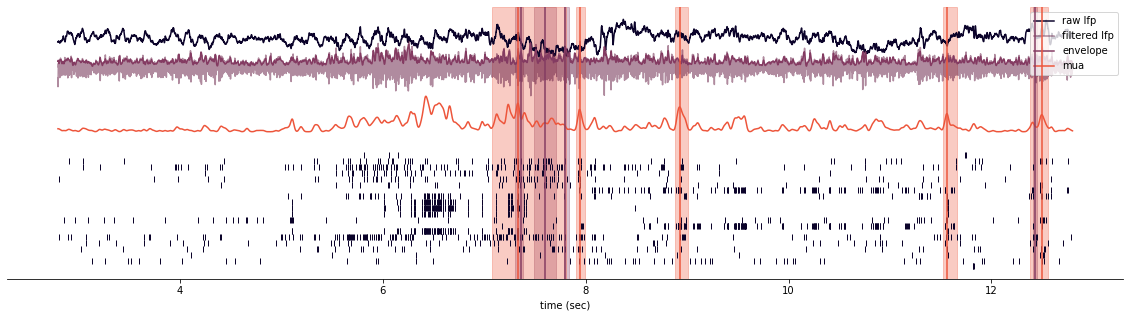

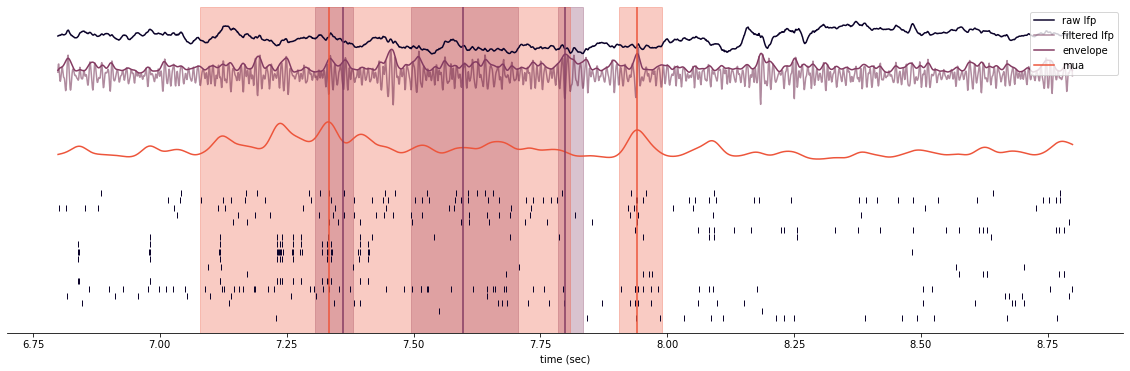

In [87]:
rip_n = 2
fig, ax = plt.subplots(1,1,figsize=(20, 5))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=5,rip_n=rip_n)

fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=1,rip_n=rip_n)

### make sure the overlap between ripple and mua is substantial

In [ ]:
# def get_mua_fr(session,dt = 0.001):
#     # load spikes
#     data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
#     spike_times = get_spikes(data_path+session+'.mat')
#     # bin spikes into single vector
#     st = list(itertools.chain.from_iterable(spike_times))
#     multiunit, _ = np.histogram(st,bins=np.arange(0, max(st), dt))
#     # timestamps for binned spikes
#     ts_mua = np.arange(0 + dt/2, max(st) - dt/2, dt)
#     return ts_mua,get_multiunit_population_firing_rate(np.expand_dims(multiunit, axis=1), 1/dt, 0.015)

# def get_percent_overlap(df):
#     above_mean = []
#     # loop through each session
#     for session in pd.unique(df.session):
#         # pull out individual session
#         temp_df = df[df.session == session]
#         # get z scored mua firing rate
#         ts_mua, fr = get_mua_fr(session)
#         zscored_fr = stats.zscore(fr,axis=0)
#         # loop through each ripple event
#         for event in temp_df.itertuples():
#             # pull out mua firing rate during ripple
#             mua_values = zscored_fr[(ts_mua >= event.start_time) & (ts_mua <= event.end_time)]
#             # calculate the proportion where mua values are above the mean and save
#             above_mean.append(sum(mua_values > 0) / len(mua_values))
#     return above_mean

# above_mean = get_percent_overlap(df)
# df['ripple_mua_overlap'] = above_mean

# plt.figure(figsize=(20,4))
# plt.plot(above_mean)

# plt.figure(figsize=(4,4))
# plt.hist(above_mean,100)
# plt.show()


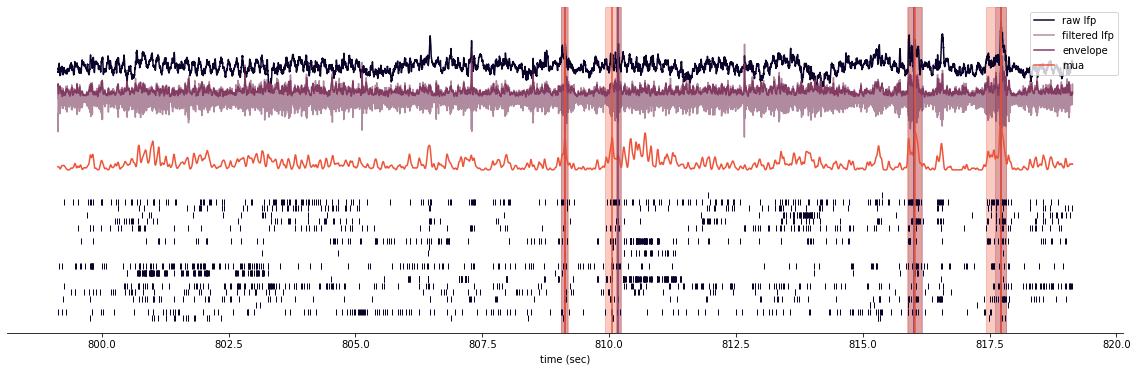

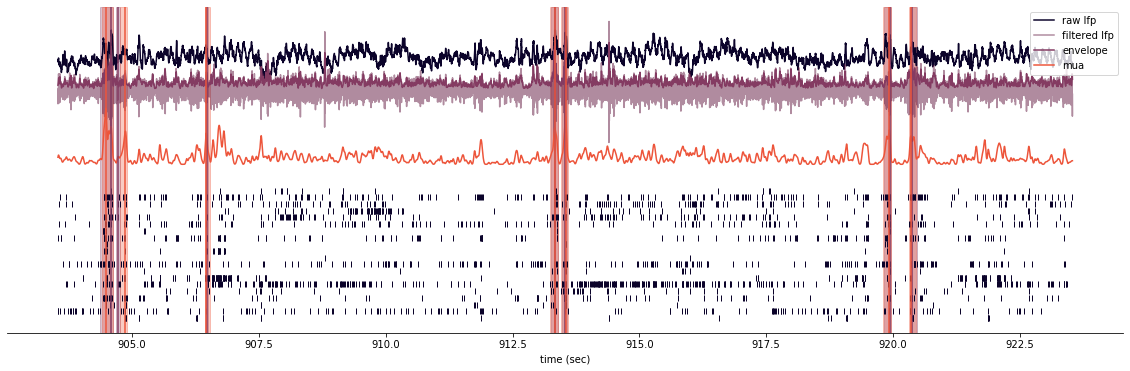

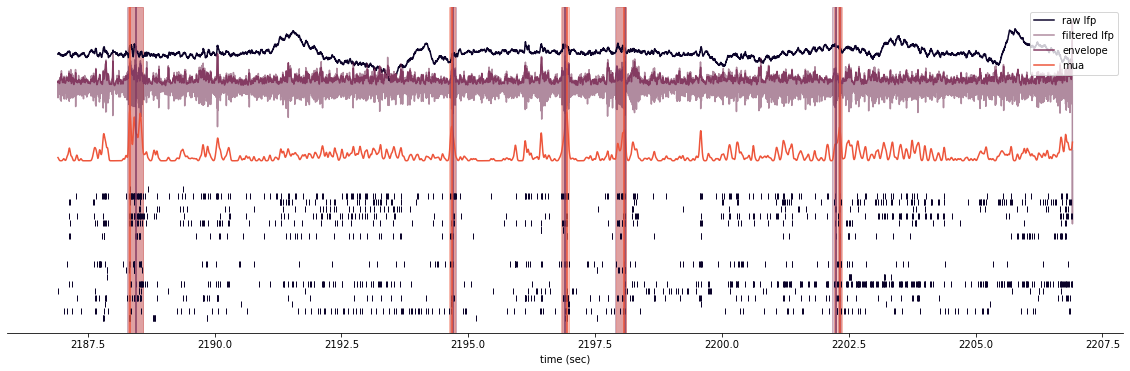

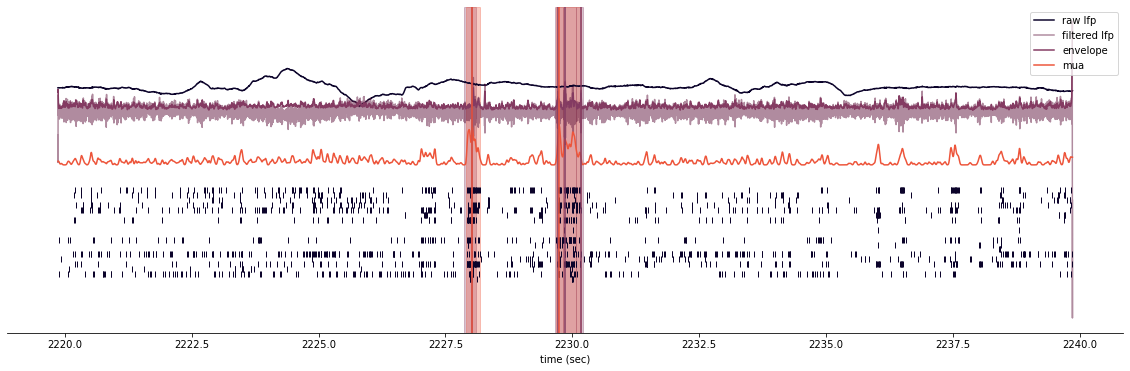

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=92)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=107)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=294)
fig, ax = plt.subplots(1,1,figsize=(20, 6))    
plot_traces(ax,df,df_mua,ts_lfp,ts_mua,lfp,firing_rate,'LEM3216_S20190805141510',lims=10,rip_n=307)

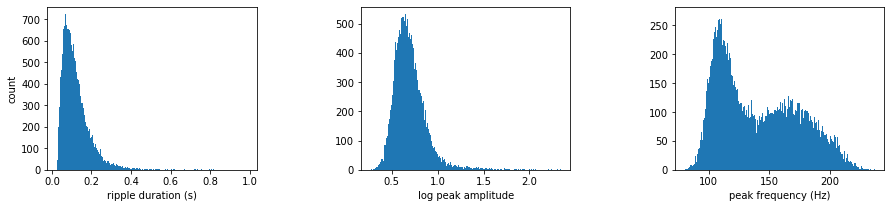

In [43]:
fig, axs = plt.subplots(1,3, figsize=(15, 3), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

axs[0].hist(df.ripple_duration,200)
axs[0].set_ylabel('count')
axs[0].set_xlabel('ripple duration (s)')

axs[1].hist(np.log10(df.peak_amplitude),200)
axs[1].set_xlabel('log peak amplitude')

axs[2].hist(df.peak_freq,200)
axs[2].set_xlabel('peak frequency (Hz)')

plt.show()

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['ripple_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['freq_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['filtered_map'][idx].T)
    axs[i].set_title(s)

In [ ]:
session_list = pd.unique(df.session)
n_columns = 5
n_rows = math.ceil(len(session_list)/n_columns) 

fig, axs = plt.subplots(n_rows,n_columns, figsize=(20, 150), edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

for i,s in enumerate(session_list):
    idx = df.session == s
    axs[i].plot(ripple_maps['amp_map'][idx].T)
    axs[i].set_title(s)